# Power integrity analysis
This example shows how to use the Ansys Electronics Database (EDB) for power integrity analysis. The
EDB is loaded into HFSS 3D Layout for analysis and postprocessing.

- Set up EDB consists of these steps:

    - Assign S-parameter model to components.
    - Create pin groups.
    - Create ports.
    - Create SIwave SYZ analysis.
    - Create cutout.

- Import EDB into HFSS 3D Layout:

    - Analyze.
    - Plot ``$Z_{11}$``.

Keywords: **HFSS 3D Layout**, **power integrity**.

## Perform imports and define constants
Import the required packages

In [1]:
import json
import os
import tempfile
import time

In [2]:
import ansys.aedt.core
from ansys.aedt.core.downloads import download_file

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

Download the example PCB data.

In [5]:
aedb = download_file(source="edb/ANSYS-HSD_V1.aedb", destination=temp_folder.name)
download_file(
    source="touchstone",
    name="GRM32_DC0V_25degC_series.s2p",
    destination=temp_folder.name,
)

'C:\\Users\\ansys\\AppData\\Local\\Temp\\tmpe_q87skl.ansys\\touchstone\\GRM32_DC0V_25degC_series.s2p'

## Create configuration file
This example uses a configuration file to set up the layout for analysis.
Initialize and create an empty dictionary to host all configurations.

In [6]:
cfg = dict()

Assigns S-parameter models to capacitors.
The first step is to use the "general" key to specify where the S-parameter files can be found.

In [7]:
cfg["general"] = {"s_parameter_library": os.path.join(temp_folder.name, "touchstone")}

## Assign model to capactitors
The model ``GRM32_DC0V_25degC_series.s2p`` is assigned to capacitors C3 and C4, which share the same component part number.
When "apply_to_all" is ``True``, all components having the part number "CAPC3216X180X20ML20" are assigned the S-parameter model.

In [8]:
cfg["s_parameters"] = [
    {
        "name": "GRM32_DC0V_25degC_series",
        "component_definition": "CAPC0603X33X15LL03T05",
        "file_path": "GRM32_DC0V_25degC_series.s2p",
        "apply_to_all": False,
        "components": ["C110", "C206"],
        "reference_net": "GND",
        "reference_net_per_component": {"C110": "GND"},
    }
]

## Create pin groups
Pins can be grouped explicitly by the pin name, or pin groups can be assigned by net name using the ''net'' key.
The following code combine the listed pins on component U2 into two pin groups using the ``net`` key.

In [9]:
cfg["pin_groups"] = [
    {
        "name": "PIN_GROUP_1",
        "reference_designator": "U1",
        "pins": ["AD14", "AD15", "AD16", "AD17"],
    },
    {"name": "PIN_GROUP_2", "reference_designator": "U1", "net": "GND"},
]

## Create ports
Create a circuit port between the two pin groups just created.

In [10]:
cfg["ports"] = [
    {
        "name": "port1",
        "reference_designator": "U1",
        "type": "circuit",
        "positive_terminal": {"pin_group": "PIN_GROUP_1"},
        "negative_terminal": {"pin_group": "PIN_GROUP_2"},
    }
]

## Create SIwave SYZ analysis setup
Both SIwave and HFSS can be used to run an analysis in the 3D Layout user interface.

In [11]:
cfg["setups"] = [
    {
        "name": "siwave_syz",
        "type": "siwave_syz",
        "pi_slider_position": 1,
        "freq_sweep": [
            {
                "name": "Sweep1",
                "type": "Interpolation",
                "frequencies": [
                    {
                        "distribution": "log scale",
                        "start": 1e6,
                        "stop": 1e9,
                        "samples": 20,
                    }
                ],
            }
        ],
    }
]

## Define cutout
Define the region of the PCB to be cut out for analysis.

In [12]:
cfg["operations"] = {
    "cutout": {
        "signal_list": ["1V0"],
        "reference_list": ["GND"],
        "extent_type": "ConvexHull",
        "expansion_size": 0.002,
        "use_round_corner": False,
        "output_aedb_path": "",
        "open_cutout_at_end": True,
        "use_pyaedt_cutout": True,
        "number_of_threads": 4,
        "use_pyaedt_extent_computing": True,
        "extent_defeature": 0,
        "remove_single_pin_components": False,
        "custom_extent": "",
        "custom_extent_units": "mm",
        "include_partial_instances": False,
        "keep_voids": True,
        "check_terminals": False,
        "include_pingroups": False,
        "expansion_factor": 0,
        "maximum_iterations": 10,
        "preserve_components_with_model": False,
        "simple_pad_check": True,
        "keep_lines_as_path": False,
    }
}

## Save configuration

Save the configuration file to a JSON file and apply it to layout data using the EDB.

In [13]:
pi_json = os.path.join(temp_folder.name, "pi.json")
with open(pi_json, "w") as f:
    json.dump(cfg, f, indent=4, ensure_ascii=False)

## Load configuration into EDB

Load the configuration into EDB from the JSON file.

In [14]:
edbapp = ansys.aedt.core.Edb(aedb, edbversion=AEDT_VERSION)
edbapp.configuration.load(config_file=pi_json)
edbapp.configuration.run()
edbapp.save()
edbapp.close()

PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.31.0


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: Database ANSYS-HSD_V1.aedb Opened in 2024.2


PyAEDT INFO: Cell main Opened


PyAEDT INFO: Builder was initialized.


PyAEDT INFO: EDB initialized.


PyAEDT INFO: Cutout Multithread started.


PyAEDT INFO: Net clean up Elapsed time: 0m 2sec


PyAEDT INFO: Extent Creation Elapsed time: 0m 0sec


PyAEDT INFO: 1310 Padstack Instances deleted. Elapsed time: 0m 1sec


PyAEDT INFO: 265 Primitives deleted. Elapsed time: 0m 3sec


PyAEDT INFO: 702 components deleted


PyAEDT INFO: Cutout completed. Elapsed time: 0m 6sec


True

The configured EDB file is saved in the temporary folder.

In [15]:
print(temp_folder.name)

C:\Users\ansys\AppData\Local\Temp\tmpe_q87skl.ansys


## Analyze in HFSS 3D Layout

### Load EDB into HFSS 3D Layout

In [16]:
h3d = ansys.aedt.core.Hfss3dLayout(
    aedb, version=AEDT_VERSION, non_graphical=NG_MODE, new_desktop=True
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_5d5e1ea1-8712-4773-b59d-0ff566812b10.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 60156


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 6140.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmpe_q87skl.ansys\edb/ANSYS-HSD_V1.aedb has been imported to project ANSYS-HSD_V1


PyAEDT INFO: Active Design set to 0;main


PyAEDT INFO: Aedt Objects correctly read


### Analyze

In [17]:
h3d.analyze(cores=NUM_CORES)

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Solving all design setups.


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Design setup None solved correctly in 0.0h 0.0m 33.0s


True

### Plot impedance

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpe_q87skl.ansys/edb/ANSYS-HSD_V1.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpe_q87skl.ansys/edb/ANSYS-HSD_V1.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.04688286781311035


PyAEDT INFO: Loading Modeler.


PyAEDT INFO: Modeler loaded.


PyAEDT INFO: EDB loaded.


PyAEDT INFO: Layers loaded.


PyAEDT INFO: Primitives loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


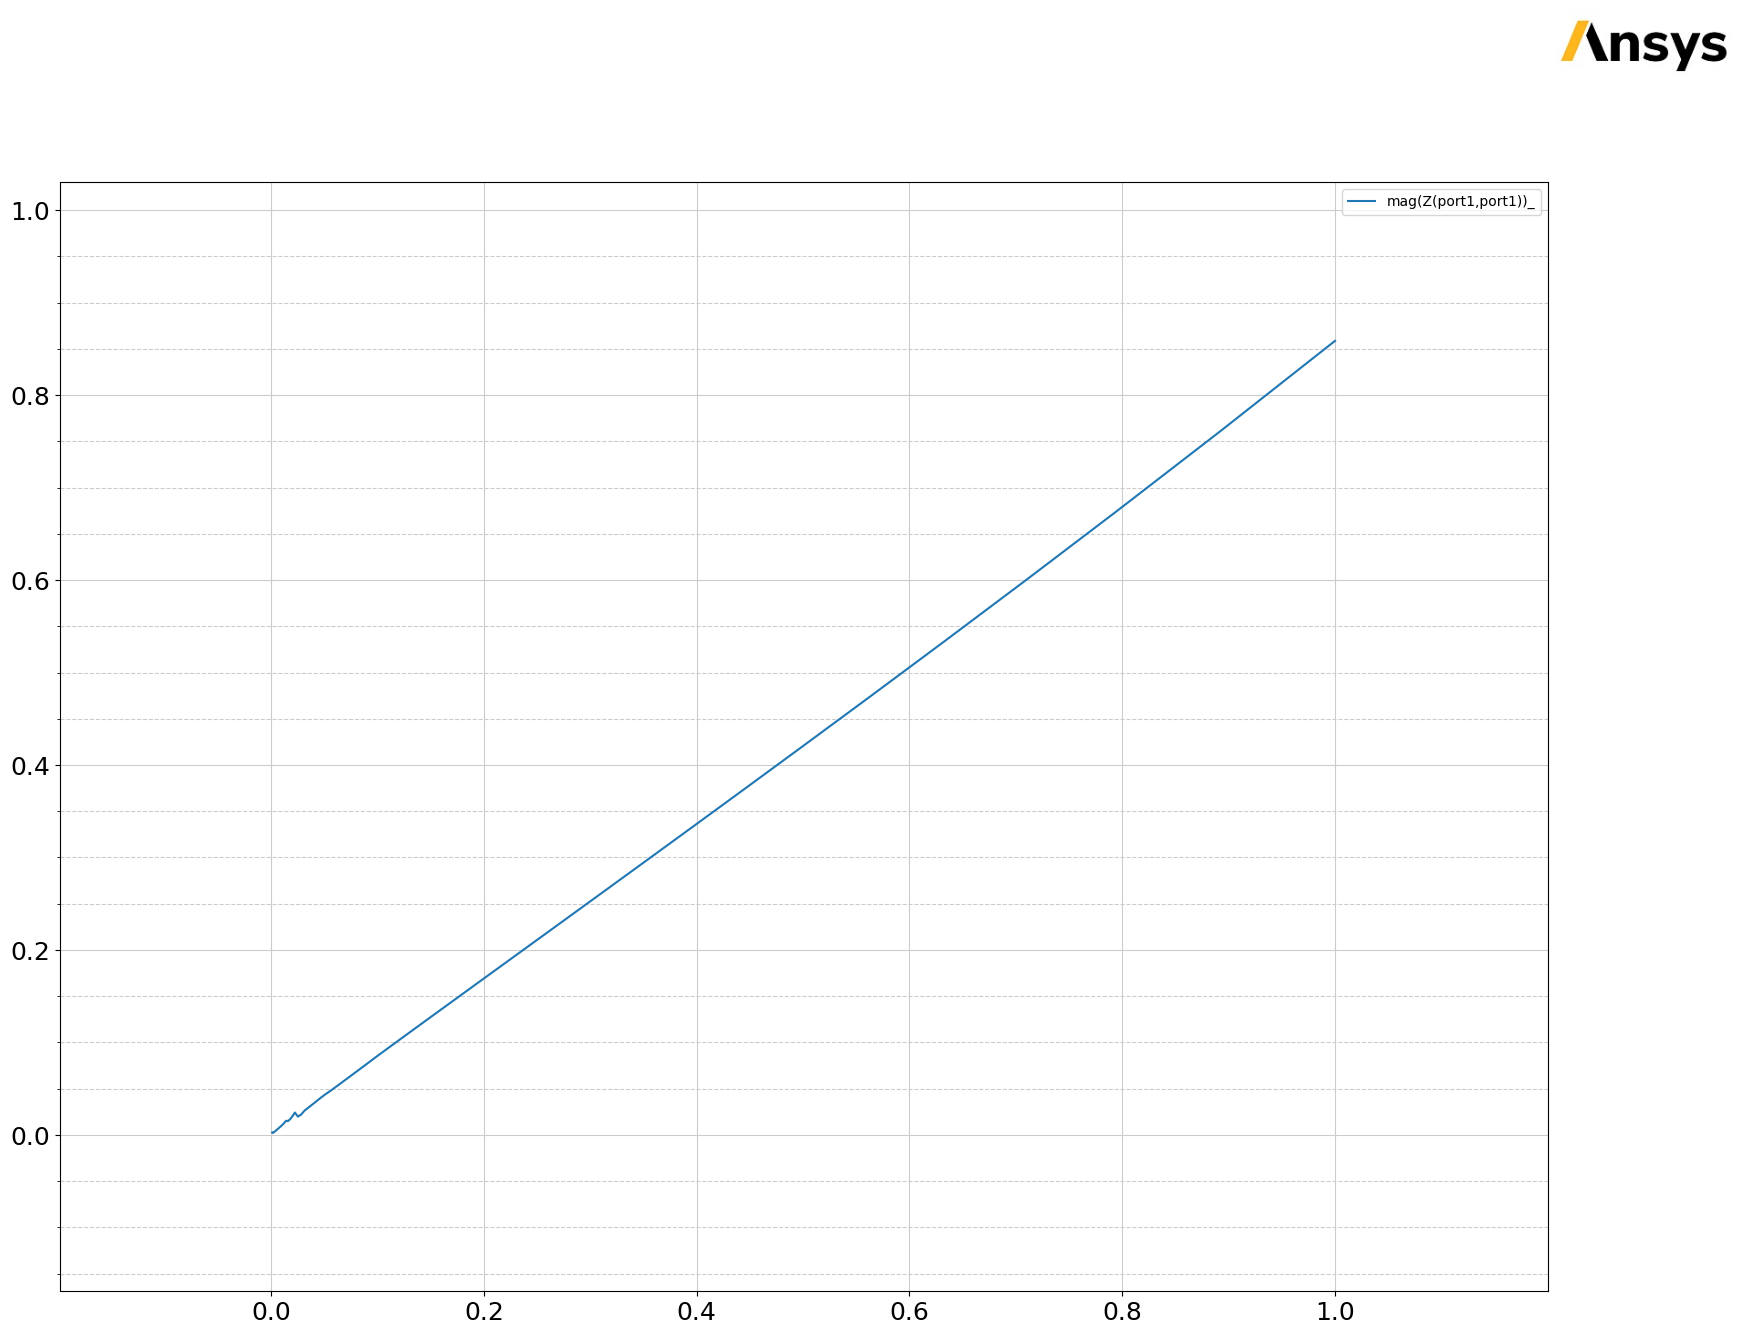

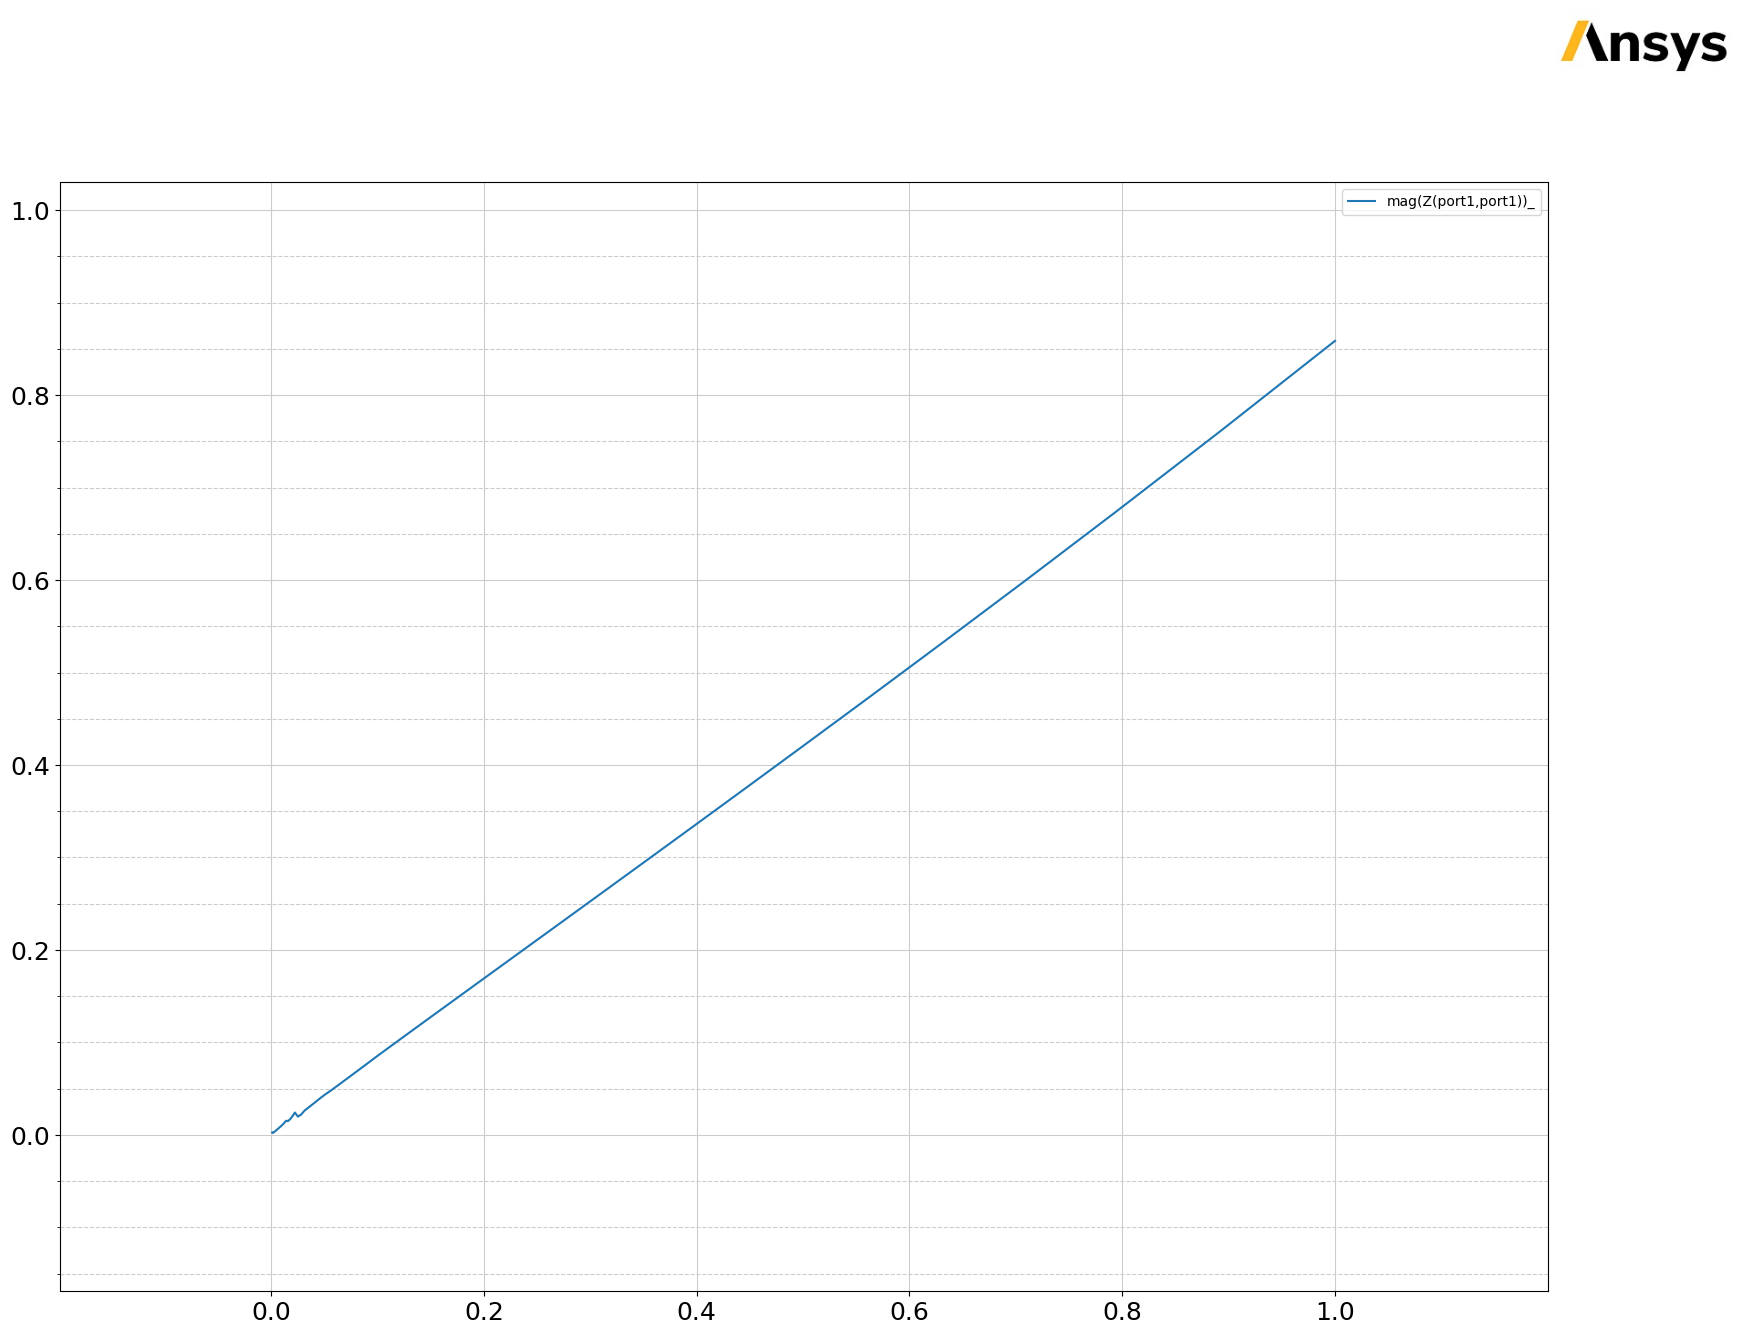

In [18]:
solutions = h3d.post.get_solution_data(expressions="Z(port1,port1)")
solutions.plot()

## Release AEDT

In [19]:
h3d.save_project()
h3d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project ANSYS-HSD_V1 Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [20]:
temp_folder.cleanup()